# Initialisation

In [502]:
import write_files as wf
import lpse_data as ld
import random_srs as rs
import matplotlib.pyplot as plt
import numpy as np
import copy
import pickle
import ihp
from functools import partial
from time import time as stopwatch
import calc_inputs as ci
import scipy.constants as scc
import ihp

# Ipython magic features
%load_ext autoreload
%autoreload 2
  
# LPSE class
lpse = ld.lpse_case()
lpse.dfp = './data/lpse.' # Data file prefix
lpse.verbose = False # Show prints
lpse.np = 1 # Number of processors
lpse.bin = '/home/space/phrfqm/lpse-3.2.11/bin/lpse_cpu' # Binary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Base case setup

In [503]:
jc = wf.job_control()
jc.version = '3.2.11' 
jc.seed = 1 # 0 for random, otherwise fixed seed
jc.resources.heartbeatInterval = 0.1 # minutes
lpse.add_class(jc)

In [504]:
gr = wf.gridding()
gr.grid.sizes = 108 # microns
gr.grid.nodes = 4321
gr.grid.antiAliasing.range = 0.333
gr.grid.antiAliasing.isAutomatic = 'false'
lpse.add_class(gr)

In [505]:
cm = wf.components()
cm.laser.enable = 'true'
cm.raman.enable = 'true'
cm.lw.enable = 'true'
cm.iaw.enable = 'false'
lpse.add_class(cm)

In [506]:
tc = wf.temporal_control()
tc.simulation.samplePeriod = 0.01 # ps
tc.simulation.time.end = 2 # ps
lpse.add_class(tc)

In [507]:
io = wf.io_control()
io.grid.downSampleFactors = 4 # Spatial
io.laser.save.S0.x = lpse.dfp + 'S0_x'
io.raman.save.S0.x = lpse.dfp + 'S1_x'
io.laser.save.E0.z = lpse.dfp + 'E0_z'
io.raman.save.E0.z = lpse.dfp + 'E1_z'
io.lw.save.pots = lpse.dfp + 'pots'
lpse.add_class(io)

In [508]:
pp = wf.physical_parameters()
pp.physical.Z = 1
pp.physical.Te = 4.5 # keV
pp.physical.Ti = 4.5 # keV
pp.physical.MiOverMe =  1836.15
pp.lw.envelopeDensity = 0.15
lpse.plasmaFrequencyDensity = 0.15
pp.densityProfile.shape = 'exp'
pp.densityProfile.geometry = 'cartesian'
pp.densityProfile.NminOverNc = 0.1357
pp.densityProfile.NmaxOverNc = 0.1658
pp.densityProfile.NminLocation = '-50 0 0'
pp.densityProfile.NmaxLocation = '50 0 0'
lpse.add_class(pp)

In [509]:
lc = wf.light_control()
lc.laser.wavelength = 0.351 # microns
lc.laser.pumpDepletion.SRS.enable = 'true'
lc.laser.ionAcousticPerturbations.enable = 'true'
lc.laser.evolution.Labc = 3 # microns
lc.laser.evolution.Loff = 1 # microns
lc.laser.evolution.riseTime = 30
lc.laser.evolution.absorption = 0
lc.raman.sourceTerm.lw.enable = 'true'
lc.raman.ionAcousticPerturbations.enable = 'true'
lc.raman.evolution.Labc = 3
lc.raman.evolution.Loff = 1 
lc.raman.evolution.riseTime = 30
lc.raman.evolution.absorption = 0
# fd solvers
lc.laser.solver = 'fd'
lc.laser.evolution.solverOrder = 2
lc.laser.evolution.dtFraction = 0.95
lc.raman.solver = 'fd'
lc.raman.evolution.solverOrder = 2
lc.raman.evolution.dtFraction = 0.95
# spectral solvers
# lc.laser.solver = 'spectral'
# lc.laser.spectral.dt = 2e-6 # ps
# lc.raman.solver = 'spectral'
# lc.raman.spectral.dt = 2e-6
lpse.add_class(lc)

In [654]:
ls = wf.light_source()
ls.laser.nBeams = 1
ls.laser.intensity = ['2e+15'] # W/cm^2
ls.laser.phase = [0] # degrees
ls.laser.polarization = [90] # degrees
ls.laser.direction = ['1 0 0']
ls.laser.frequencyShift = [0]
ls.laser.group = [0]
ls.laser.evolution.source = ['min.x']
ls.laser.evolution.offset = ['0 0 0'] # microns
ls.laser.evolution.width = [10] # Half-width at 1/e of sgauss [um]
ls.laser.evolution.sgOrder = [4]
ls.raman.nBeams = 1
ls.raman.intensity = ['8e+10' for i in range(ls.raman.nBeams)] # W/cm^2
ls.raman.phase = [0 for i in range(ls.raman.nBeams)] # degrees
ls.raman.polarization = [90 for i in range(ls.raman.nBeams)] # degrees
ls.raman.direction = ['-1 0 0' for i in range(ls.raman.nBeams)]
ls.raman.frequencyShift = [0]
ls.raman.group = [0]
ls.raman.evolution.source = ['max.x' for i in range(ls.raman.nBeams)]
ls.raman.evolution.offset = ['0 0 0' for i in range(ls.raman.nBeams)] # microns
ls.raman.evolution.width = [0 for i in range(ls.raman.nBeams)] # Half-width at 1/e of sgauss [um]
ls.raman.evolution.sgOrder = [4 for i in range(ls.raman.nBeams)]
lpse.add_class(ls)

In [511]:
lwc = wf.lw_control()
lwc.lw.SRS.enable = 'true'
lwc.lw.ionAcousticPerturbations.enable = 'true'
lwc.lw.spectral.dt = 2e-6 # ps
lwc.lw.Labc = 3 # microns
lwc.lw.noise.enable = 'false'
lwc.lw.noise.isCalculated = 'false'
lwc.lw.noise.amplitude = 0.001
lwc.lw.collisionalDampingRate = 0.0
lwc.lw.__dict__['collisionalDampingRate.isCalculated'] = 'false'
lwc.lw.landauDamping.enable = 'true'
lwc.lw.kFilter.enable = 'false'
lwc.lw.kFilter.scale = 1.2
lpse.add_class(lwc)

In [512]:
iawc = wf.iaw_control()
iawc.iaw.solver = 'spectral'
iawc.iaw.sourceTerm.lw.enable = 'true'
iawc.iaw.sourceTerm.laser.enable = 'true'
iawc.iaw.sourceTerm.raman.enable = 'true'
iawc.iaw.spectral.dt = 1e-3
iawc.iaw.Labc = 3
iawc.iaw.dampingRate = 0.0
lpse.add_class(iawc)

In [513]:
ins = wf.instrumentation()
ins.metrics.enable = 'true'
ins.metrics.file = lpse.dfp + 'metrics'
ins.metrics.samplePeriod = 0.01 # ps
lpse.add_class(ins)

In [514]:
pert = wf.initial_perturbation()
pert.initialPerturbation.enable = 'false'
pert.initialPerturbation.field = 'E1_z'
pert.initialPerturbation.type = 'planeWave'
pert.initialPerturbation.wavelength = 1 # set after calcs
pert.initialPerturbation.direction = '[-1 0 0]'
pert.initialPerturbation.envelopeSize = '[0 0 0]' # infinite
pert.initialPerturbation.envelopeOffset = '[0 0 0]'
pert.initialPerturbation.amplitude = 1 # set after calcs
lpse.add_class(pert)

# List of density profile classes

In [515]:
# format ppxy where x = L_n, y = n_mid, and 1,2,3 = low, mid, high
pp22 = copy.deepcopy(pp)
pp12 = copy.deepcopy(pp)
pp12.densityProfile.NminOverNc = 0.1270
pp12.densityProfile.NmaxOverNc = 0.1772
pp21 = copy.deepcopy(pp)
pp21.lw.envelopeDensity = 0.12
pp21.densityProfile.NminOverNc = 0.1086
pp21.densityProfile.NmaxOverNc = 0.1326
pp23 = copy.deepcopy(pp)
pp23.lw.envelopeDensity = 0.20
pp23.densityProfile.NminOverNc = 0.181
pp23.densityProfile.NmaxOverNc = 0.221
pp32 = copy.deepcopy(pp)
pp32.densityProfile.NminOverNc = 0.1427
pp32.densityProfile.NmaxOverNc = 0.1577
dens = [pp12,pp21,pp22,pp23,pp32]
I14s = [7.956e10,5.822e10,7.341e10,9.437e10,6.451e10]
dlabs = ['Ln=300um; nmid=0.15','Ln=500um; nmid=0.12',\
         'Ln=500um; nmid=0.15','Ln=500um; nmid=0.20',\
         'Ln=1000um; nmid=0.15']

In [516]:
# Single run point
splits = 1; cpw = 8; tavg = tc.simulation.time.end-1
for i in range(3,4):
  lpse.add_class(dens[i])
  rs.Isrs14(I14s[i],lpse,tavg,splits,cpw,False,True,True)
  isrstest = rs.Isrs(lpse,tavg,splits,cpw,True)

Using 2832 cells.
LW envelope density is: 0.2350
AA range is: 0.333
Laser spectral dt is: 2.46e-04 ps
Raman spectral dt is: 1.27e-04 ps
LW spectral dt is: 1.19e-04 ps
Time taken: 44.579 s
<I_srs>: -1.164e+11 W/cm^2
Intensity sum: 1.164e+11 W/cm^2
Intensity average: 1.164e+11 W/cm^2
Total time taken: 44.579 s
Raman seed intensity: 6.487e+10 W/cm^2
Using 2832 cells.
LW envelope density is: 0.2350
AA range is: 0.333
Laser spectral dt is: 2.46e-04 ps
Raman spectral dt is: 1.27e-04 ps
LW spectral dt is: 1.19e-04 ps
Time taken: 46.272 s
<I_srs>: -9.235e+13 W/cm^2
Intensity sum: 9.235e+13 W/cm^2
Intensity average: 9.235e+13 W/cm^2
Total time taken: 46.272 s


In [517]:
lpse.fields()

<IPython.core.display.Javascript object>


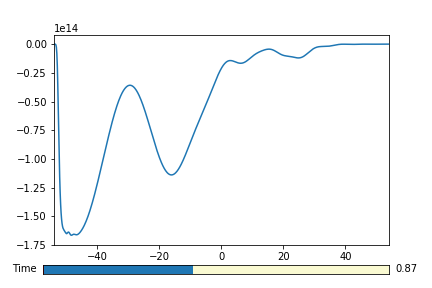

In [523]:
%matplotlib notebook
lpse.plot_field('S1_x')

<IPython.core.display.Javascript object>


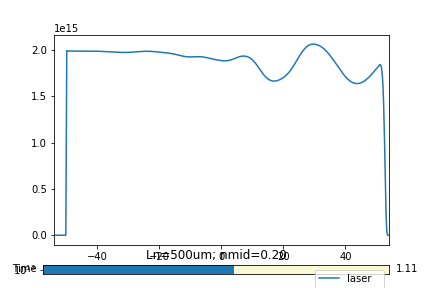

In [524]:
lpse.plot_field('S0_x')

# Run cases and get $<I_{srs}>$ curves

In [643]:
# Isrs curves
fresh_results = False
Irange = np.logspace(14,16,20)
cpus = 2; splits = 3; cpw = 8
tavg = tc.simulation.time.end; parallel = True
if fresh_results:
  t0 = stopwatch()
  isrs = rs.Isrs_dens(lpse,dens[:2],dlabs[:2],tavg,I14s[:2],\
                      Irange,parallel,cpus,splits,cpw)
  t1 = stopwatch()
  print(f'Time taken: {t1-t0:0.3f}s')
  with open('isrsscrap.pickle', 'wb') as f:
    pickle.dump(isrs, f)
else:
  with open('raman_fit_3splits.pickle', 'rb') as f:
    isrs = pickle.load(f)

In [644]:
parallel = False
if fresh_results:
  t0 = stopwatch()
  isrsrt = rs.Isrs_dens(lpse,dens,dlabs,tavg,I14s,\
                      Irange,parallel,cpus,splits,cpw,rt=True)
  t1 = stopwatch()
  print(f'Time taken: {t1-t0:0.3f}s')
  with open('isrs_rt.pickle', 'wb') as f:
    pickle.dump(isrsrt, f)
else:
  with open('isrs_rt.pickle', 'rb') as f:
    isrsrt = pickle.load(f)

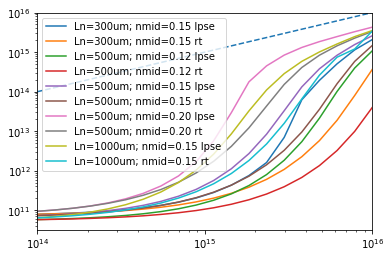

In [646]:
# Plot curves
%matplotlib inline
for i in range(len(dlabs)):
  plt.loglog(Irange,isrs[dlabs[i]],label=dlabs[i]+' lpse')
  plt.loglog(Irange,isrsrt[dlabs[i]],label=dlabs[i]+' rt')
plt.loglog(Irange,Irange,'--')
plt.ylim(None,1e16)
plt.xlim(1e14,1e16)
plt.legend()
plt.show()

In [640]:
# Extract experimental datasets
lasI = {}; srsI = {}
srcs = ['epoch','fluid']
vals = ['low','mid','high']
typs = ['scale','dens']
fnames = [f'SJdata/{i}_srs_{j}_{k}.csv' \
          for i in srcs for j in vals for k in typs]
for i,j in enumerate(fnames):
  lasI[i] = []; srsI[i] = []
  with open(j,'r') as fp:
    for line in fp:
      lin = line.strip().split(',')
      lasI[i].append(float(lin[0]))
      srsI[i].append(float(lin[1]))

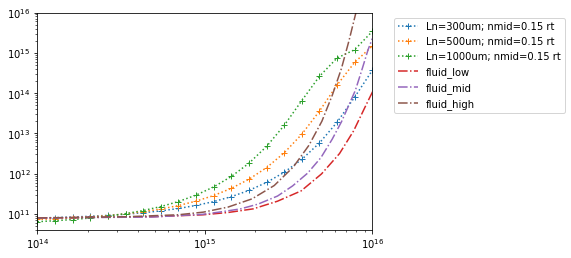

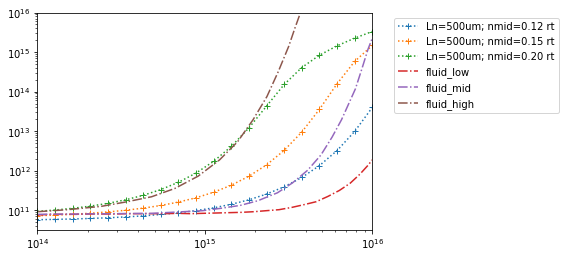

In [661]:
# Plot paper figures
lpseplt = False; rtplt = True; epochplt = False; fluidplt = True
%matplotlib inline
fig1 = [0,2,4]; fig2 = [1,2,3]
fig1_epoch = [0,2,4]; fig2_epoch = [1,3,5]
fig1_fluid = [6,8,10]; fig2_fluid = [7,9,11]
labels = [f'{i}_{j}' for i in srcs for j in vals for k in range(2)]
for i in fig1:
  if lpseplt:
    plt.loglog(Irange,isrs[dlabs[i]],label=dlabs[i]+' lpse')
  if rtplt:
    plt.loglog(Irange,isrsrt[dlabs[i]],'+:',label=dlabs[i]+' rt')
for i in fig1_epoch:
#   print(f'{srsI[i][0]:0.3e}')
  if epochplt:
    plt.loglog(lasI[i],srsI[i],'x--',label=labels[i])
for i in fig1_fluid:
  if fluidplt:
    plt.loglog(lasI[i],srsI[i],'-.',label=labels[i])
# plt.loglog(Irange,Irange,'--',label='Saturation')
plt.ylim(4e10,1e16)
plt.xlim(1e14,1e16)
# plt.hlines(3.9e12,1e14,1e16)
# plt.vlines(2e15,4e10,1e16)
plt.legend(bbox_to_anchor=(1.05, 1))
# plt.grid()
plt.show()
for i in fig2:
  if lpseplt:
    plt.loglog(Irange,isrs[dlabs[i]],label=dlabs[i]+' lpse')
  if rtplt:
    plt.loglog(Irange,isrsrt[dlabs[i]],'+:',label=dlabs[i]+' rt')
for i in fig2_epoch:
#   print(f'{srsI[i][0]:0.3e}')
  if epochplt:
    plt.loglog(lasI[i],srsI[i],'x--',label=labels[i])
for i in fig2_fluid:
  if fluidplt:
    plt.loglog(lasI[i],srsI[i],'-.',label=labels[i])
# plt.loglog(Irange,Irange,'--',label='Saturation')
plt.ylim(None,1e16)
plt.xlim(1e14,1e16)
plt.legend(bbox_to_anchor=(1.05, 1))
# plt.grid()
plt.show()

6.122988011036525
4.871e+11
Time taken: 10.476431131362915 s


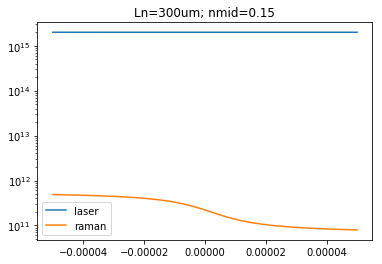

3.7678957686989216
2.194e+11
Time taken: 10.507179737091064 s


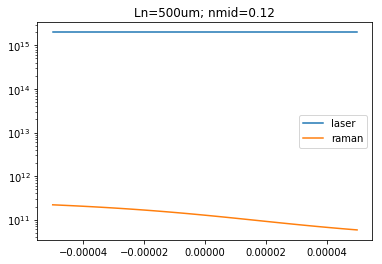

14.059623970695744
1.032e+12
Time taken: 9.983359813690186 s


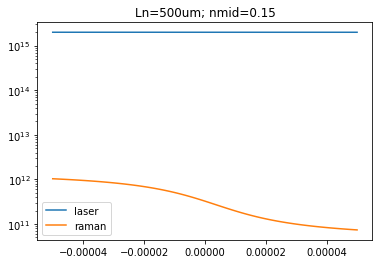

259.14445914178407
2.446e+13
Time taken: 15.436564207077026 s


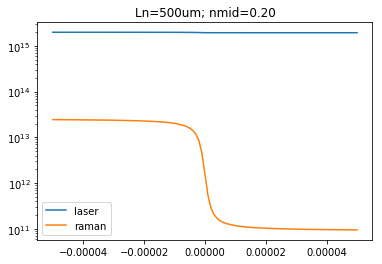

46.860512414776025
3.023e+12
Time taken: 14.326383113861084 s


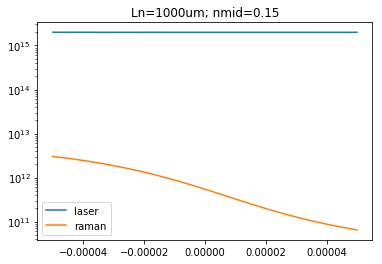

In [655]:
# Analytical solution from literature
%matplotlib inline
for i in range(5):
  t0 = stopwatch()
  lpse.add_class(dens[i])
  ls.raman.intensity = [I14s[i]]
  lpse.add_class(ls)
  x,n,I0,I1 = rs.ray_trace(lpse,points=101,return_all=True,noise=False)
  plt.semilogy(x,I0,label='laser')
  plt.semilogy(x,I1,label='raman')
  print(I1[0]/I1[-1])
  print(f'{I1[0]:0.3e}')
  t1 = stopwatch()
  print(f'Time taken: {t1-t0} s')
  # plt.plot(n,-I1,label='raman')
  plt.legend()
  plt.title(dlabs[i])
  plt.show()